In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
'''postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'fifa19'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
fifa19 = pd.read_sql_query('select * from fifa19',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()'''


"postgres_user = 'dsbc_student'\npostgres_pw = '7*.8G9QH21'\npostgres_host = '142.93.121.174'\npostgres_port = '5432'\npostgres_db = 'fifa19'\n\nengine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(\n    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))\nfifa19 = pd.read_sql_query('select * from fifa19',con=engine)\n\n# no need for an open connection, as we're only doing a single query\nengine.dispose()"

In [3]:
fifa19 = pd.read_csv('/Users/richardlafferty/Downloads/fifa19.csv')

In [4]:
fifa19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [5]:
display(fifa19.head())

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## I am going to be looking to make run a regression which will let me find with reasonabel accuracy, the value of a player in regards to his salary. My goal is to find the most pertinent variables and to use this on my next fantasy draft.

In [6]:
fifa19.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [7]:
# I think some of these are inconsequential to us and I'll drop them now
fifa19 = fifa19.drop(['Photo', 'Flag', 'Club Logo', 'ID',
                      'Jersey Number', 'Real Face', 
                      'Contract Valid Until', 'Joined'], axis=1)

In [8]:
#list of numeric columns
cont_columns = list(fifa19.select_dtypes(exclude='object'))
cat_columns = list(fifa19.select_dtypes('object'))
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
['Name', 'Nationality', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Release Clause']


In [9]:
fifa19.head()

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
fifa19.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause'],
   

In [11]:
#looking at null values
print((fifa19.isnull().sum().sort_values(ascending=False)))

Loaned From        16943
RWB                 2085
LM                  2085
CB                  2085
LCB                 2085
LB                  2085
RDM                 2085
CDM                 2085
LDM                 2085
LWB                 2085
RM                  2085
RCM                 2085
CM                  2085
LCM                 2085
RAM                 2085
RB                  2085
CAM                 2085
LAM                 2085
RW                  2085
RF                  2085
CF                  2085
LF                  2085
LW                  2085
RS                  2085
ST                  2085
LS                  2085
RCB                 2085
Release Clause      1564
Club                 241
Position              60
                   ...  
Interceptions         48
SprintSpeed           48
Volleys               48
ShortPassing          48
HeadingAccuracy       48
Finishing             48
Crossing              48
Aggression            48
LongPassing           48


In [12]:
#dropping loaned from because it's missing over 90% of its data unsurprisingly
fifa19 = fifa19.drop(['Loaned From'], axis=1)

In [13]:
fifa19.loc[fifa19.CDM.isnull()]

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,€58M,€240K,1328,...,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,€123.3M
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,€53.5M,€240K,1311,...,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,€38M,€130K,1473,...,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,€62.7M
37,37,H. Lloris,31,France,88,88,Tottenham Hotspur,€36M,€150K,1335,...,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0,€66.6M
40,40,S. Handanovič,33,Slovenia,88,88,Inter,€30M,€110K,1262,...,69.0,25.0,10.0,13.0,87.0,86.0,69.0,89.0,89.0,€51M
41,41,G. Buffon,40,Italy,88,88,Paris Saint-Germain,€4M,€77K,1334,...,70.0,13.0,11.0,11.0,88.0,87.0,74.0,90.0,83.0,€7.4M
46,46,K. Navas,31,Costa Rica,87,87,Real Madrid,€30.5M,€195K,1345,...,67.0,28.0,14.0,14.0,90.0,81.0,75.0,82.0,90.0,€62.5M
57,57,Ederson,24,Brazil,86,90,Manchester City,€41.5M,€125K,1463,...,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0,€79.9M


In [14]:
fifa19.CDM.value_counts()

62+2    660
60+2    620
61+2    620
64+2    592
59+2    592
63+2    573
58+2    565
65+2    539
57+2    529
66+2    524
56+2    520
54+2    505
55+2    479
53+2    471
51+2    468
49+2    448
52+2    444
50+2    438
68+2    428
48+2    427
67+2    426
47+2    396
69+2    362
46+2    359
44+2    339
45+2    325
70+2    302
43+2    282
71+2    271
42+2    239
       ... 
71+3      8
62+3      7
63+3      6
66+3      6
57+3      6
69+3      6
52+3      6
53+3      6
79+3      5
51+3      5
81+2      5
29+2      4
67+3      4
64+3      4
65+3      4
54+3      4
68+3      3
49+3      2
50+3      2
45+3      2
84+3      2
82+2      1
46+3      1
86+3      1
28+2      1
85+3      1
87+3      1
68+5      1
57+4      1
83+2      1
Name: CDM, Length: 99, dtype: int64

In [15]:
#all these columns have a + value added, which according to soccer friends is not important 
cols = ["LS", "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM", "LCM",
        "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB", "CB", "RCB", "RB"]
for col in cols:
    fifa19[col] = fifa19[col].str[:-2]
    fifa19[col] = fifa19[col].astype(float)

In [16]:
print(fifa19['Height'].head())
print(fifa19['Height'].isnull().sum())
fifa19['Height'].dropna(inplace=True)

0     5'7
1     6'2
2     5'9
3     6'4
4    5'11
Name: Height, dtype: object
48


In [17]:
def parse_height(ht):
    height = ht.split("'")
    #print(height) #used this to see my output after splitting
    feet = float(height[0])
    inches = float(height[1])
    return (12*feet) + inches
fifa19['Height'] = fifa19['Height'].apply(lambda x: parse_height(x))


In [18]:
#Correct Weight
fifa19['Weight']=fifa19['Weight'].str[:-3]
fifa19['Weight']=fifa19['Weight'].astype(float)

print(fifa19.Height.head())
print(fifa19.Weight.head())


0    67.0
1    74.0
2    69.0
3    76.0
4    71.0
Name: Height, dtype: float64
0    159.0
1    183.0
2    150.0
3    168.0
4    154.0
Name: Weight, dtype: float64


I feel confident that the amount of observations I have after dropping the null values can still give me a pretty high performing model

In [19]:
print(fifa19.head())

   Unnamed: 0               Name  Age Nationality  Overall  Potential  \
0           0           L. Messi   31   Argentina       94         94   
1           1  Cristiano Ronaldo   33    Portugal       94         94   
2           2          Neymar Jr   26      Brazil       92         93   
3           3             De Gea   27       Spain       91         93   
4           4       K. De Bruyne   27     Belgium       91         92   

                  Club    Value   Wage  Special  ... Composure  Marking  \
0         FC Barcelona  €110.5M  €565K     2202  ...      96.0     33.0   
1             Juventus     €77M  €405K     2228  ...      95.0     28.0   
2  Paris Saint-Germain  €118.5M  €290K     2143  ...      94.0     27.0   
3    Manchester United     €72M  €260K     1471  ...      68.0     15.0   
4      Manchester City    €102M  €355K     2281  ...      88.0     68.0   

   StandingTackle  SlidingTackle GKDiving GKHandling GKKicking  GKPositioning  \
0            28.0           2

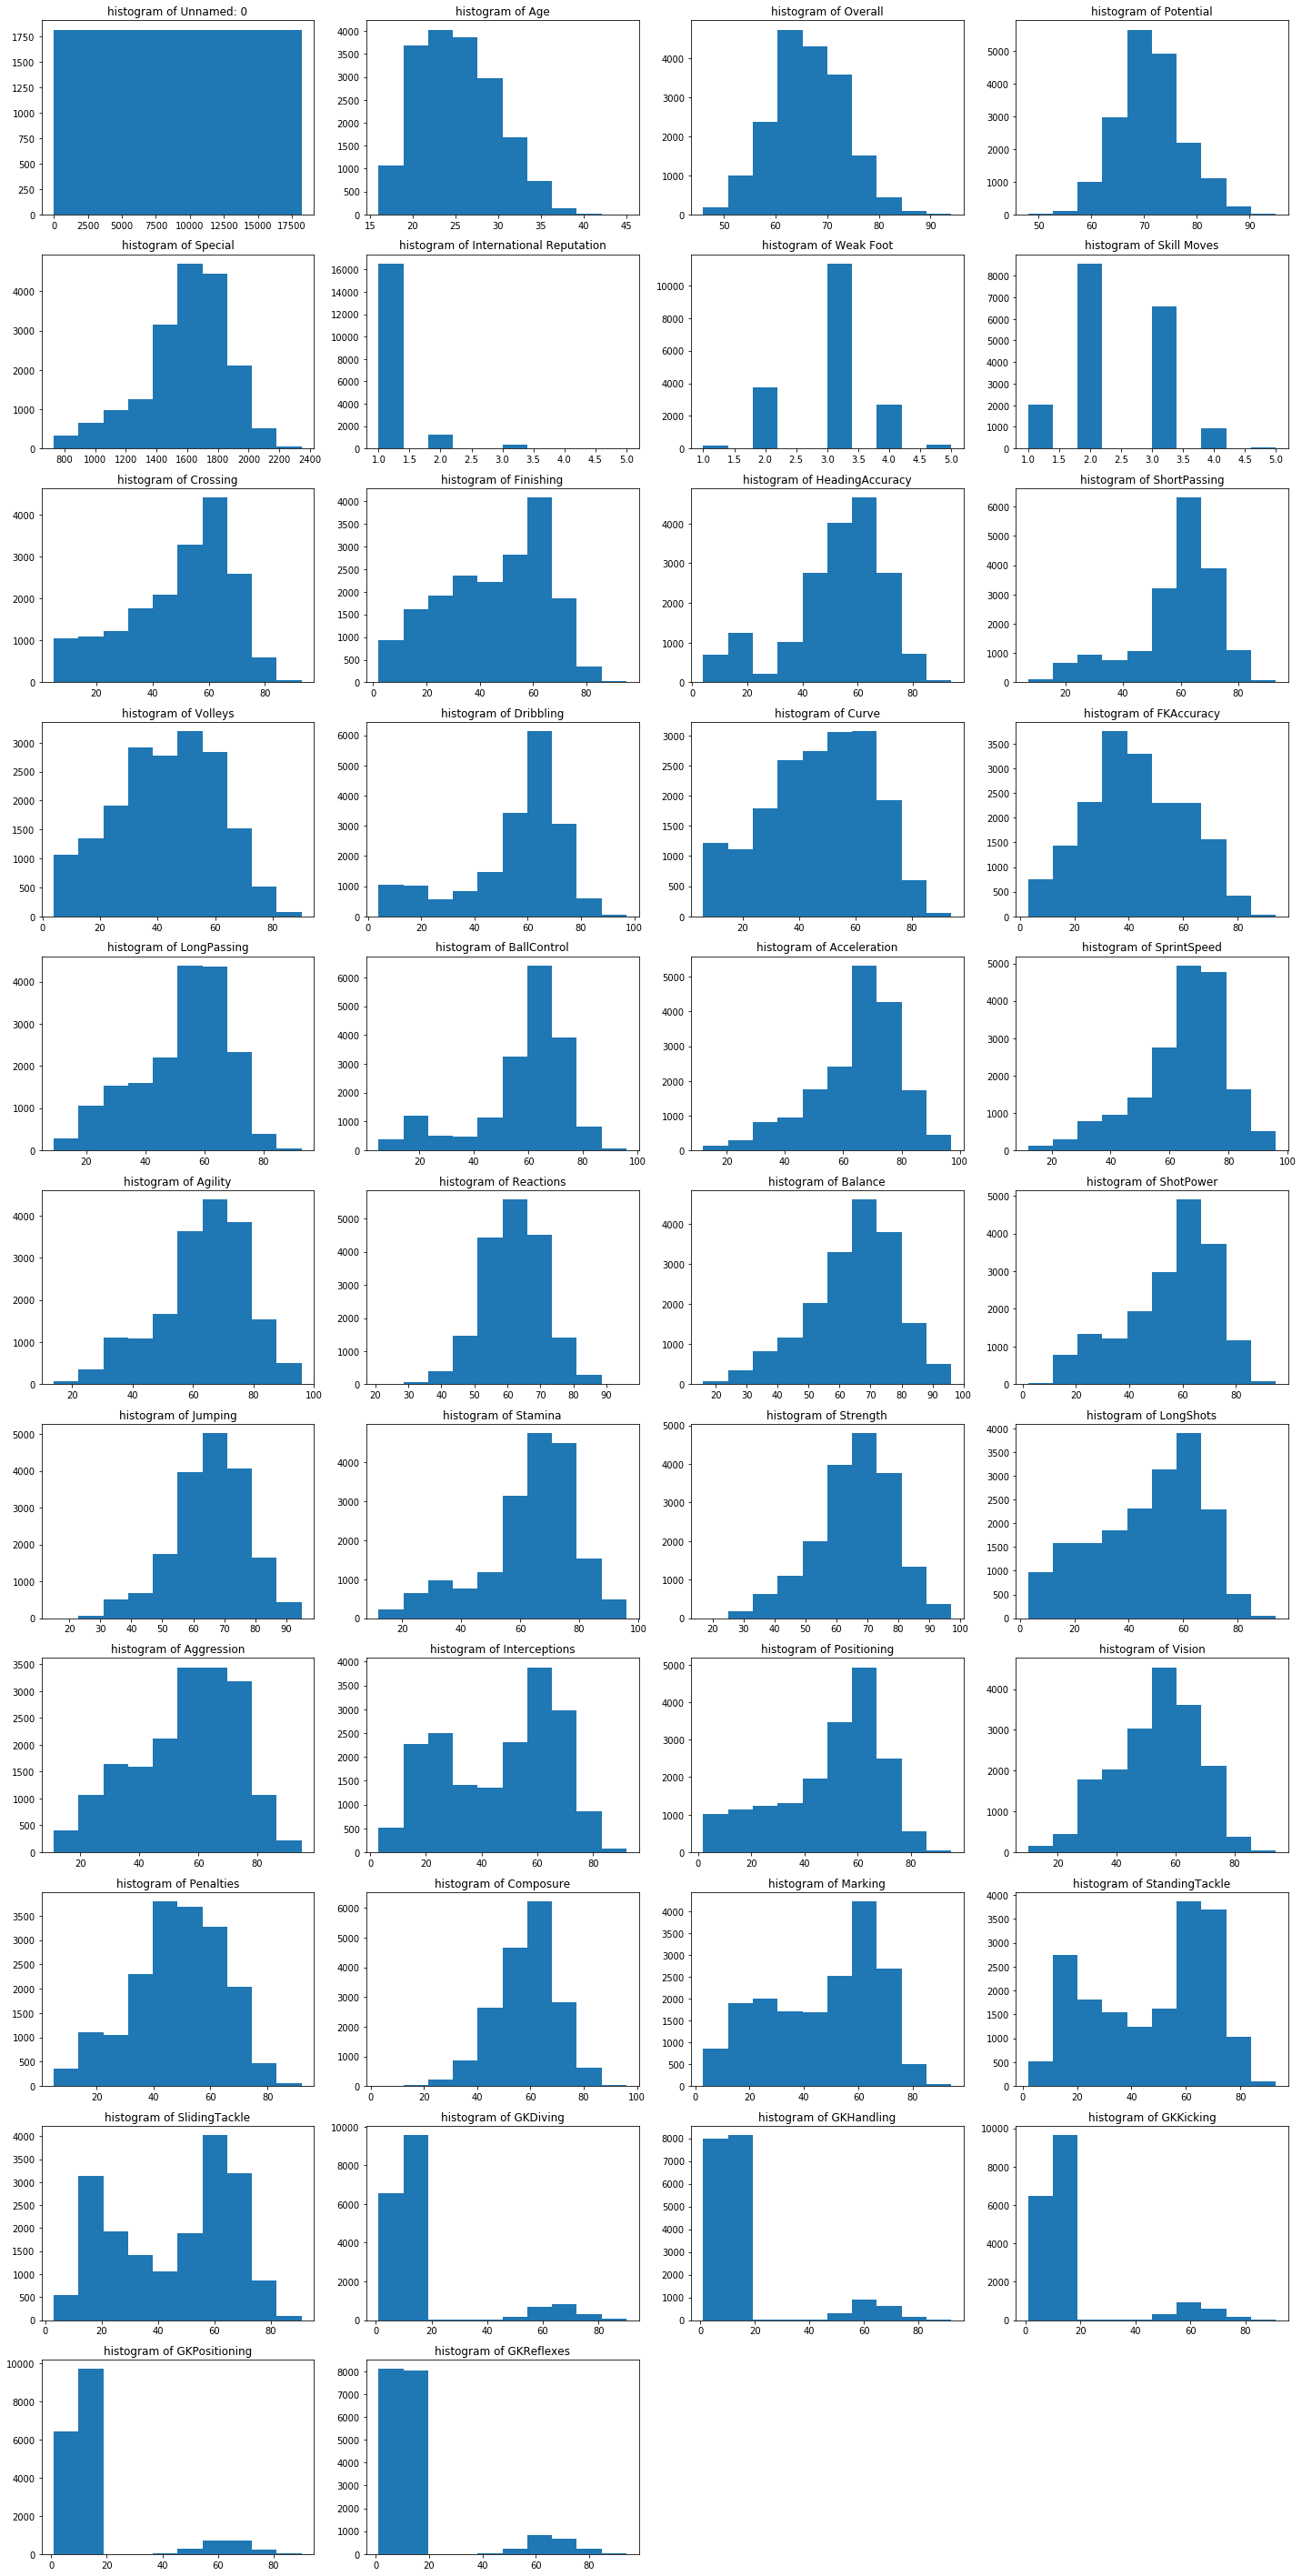

In [20]:
fig = plt.figure(figsize=(20,150))
for i, col in enumerate(cont_columns):
    
    plt.subplot(len(cont_columns), 4, i+1)
    plt.hist(fifa19[col])
    plt.title('histogram of {}'.format(col))
    plt.tight_layout()

those are some pretty fine distributions. A few categorical variables snuck in though so I'll make a new list of just continuous variables.

In [21]:
cont_columns = [i for i in cont_columns if i not in('International Reputation', 'Weak Foot', 'Skill Moves')]
print(cont_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


In [22]:
add_list = ['International Reputation', 'Weak Foot', 'Skill Moves']
cat_columns = cat_columns + add_list

In [23]:
print(cat_columns)

['Name', 'Nationality', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Release Clause', 'International Reputation', 'Weak Foot', 'Skill Moves']


In [24]:
print(cont_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


In [25]:
fifa19.Value.tail(1000)

17207    €140K
17208    €190K
17209     €10K
17210     €70K
17211    €170K
17212    €100K
17213    €100K
17214    €180K
17215       €0
17216     €90K
17217    €140K
17218    €150K
17219    €120K
17220    €180K
17221    €160K
17222    €140K
17223    €180K
17224     €90K
17225    €190K
17226    €100K
17227    €140K
17228    €180K
17229    €160K
17230    €120K
17231    €120K
17232    €160K
17233    €100K
17234    €200K
17235    €160K
17236    €110K
         ...  
18177     €70K
18178     €50K
18179     €50K
18180     €40K
18181     €50K
18182     €50K
18183       €0
18184     €40K
18185     €50K
18186     €60K
18187     €40K
18188     €60K
18189     €60K
18190     €60K
18191     €50K
18192     €50K
18193     €50K
18194     €50K
18195     €60K
18196     €60K
18197     €60K
18198     €60K
18199     €70K
18200     €60K
18201     €60K
18202     €60K
18203     €60K
18204     €60K
18205     €60K
18206     €60K
Name: Value, Length: 1000, dtype: object

In [26]:
#changing all currency columns into float columns to help analyze

curs=["Release Clause", "Value", "Wage"]
for cur in curs:
    
    def curr_value(x):
        x = str(x).replace('€', '')
        if('M' in str(x)):
            x = str(x).replace('M', '')
            x = float(x) * 1000000
        elif('K' in str(x)):
            x = str(x).replace('K', '')
            x = float(x) * 1000
        return float(x)
    fifa19[cur] = fifa19[cur].apply(curr_value)

In [27]:
cont_columns = cont_columns + curs
cat_columns = ['Name', 'Nationality', 'Club', 'Preferred Foot',
               'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight',
               'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
               'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB',
               'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
               'International Reputation', 'Weak Foot', 'Skill Moves']

In [28]:
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause', 'Value', 'Wage']
['Name', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'International Reputation', 'Weak Foot', 'Skill Moves']


In [29]:
#looking at our target variable
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
inf


In [30]:
#having an inf value will certainly mess up our model so I will try to take care of it now
fifa19.value_overall = fifa19.value_overall.replace(np.inf, np.nan)
print(fifa19.value_overall.max())
print(fifa19.value_overall.isnull().sum())
#if we only have 252 null values then I feel ok with just dropping those rows
print(fifa19.value_overall.head())



0.006
252
0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64


In [31]:
# I obviously need to deal with my nulls. I don't necessarily want to just drop them all so I'll check my options
obj_df = fifa19.select_dtypes(include=['object']).copy()
#Encoding &missing Values
cols=obj_df.columns
for col in cols:
    print(col)
    fifa19[col].replace(np.NaN,'NotAv',inplace=True)
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    labelencoder_X = LabelEncoder()
    fifa19[col] = labelencoder_X.fit_transform(fifa19[col])

Name
Nationality
Club
Preferred Foot
Work Rate
Body Type
Position


In [32]:
'''fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19.Nationality, drop_first=True, prefix='nationality')], axis=1)
fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19.Club, drop_first=True, prefix='club')], axis=1)
fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Preferred Foot'], drop_first=True, prefix='preferred food')], axis=1)
fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Work Rate'], drop_first=True, prefix='work rate')], axis=1)
fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Body Type'], drop_first=True, prefix='body type')], axis=1)
fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Position'], drop_first=True, prefix='position')], axis=1)

dummy_columns = list(pd.get_dummies(fifa19['Nationality'], drop_first=True, prefix='nationality').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Club'], drop_first=True, prefix='club').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Preferred Foot'], drop_first=True, prefix='foot').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Work Rate'], drop_first=True, prefix='work rate').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Body Type'], drop_first=True, prefix='Body Type').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Positi''on'], drop_first=True, prefix='position').columns)'''



"fifa19 = pd.concat([fifa19, pd.get_dummies(fifa19.Nationality, drop_first=True, prefix='nationality')], axis=1)\nfifa19 = pd.concat([fifa19, pd.get_dummies(fifa19.Club, drop_first=True, prefix='club')], axis=1)\nfifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Preferred Foot'], drop_first=True, prefix='preferred food')], axis=1)\nfifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Work Rate'], drop_first=True, prefix='work rate')], axis=1)\nfifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Body Type'], drop_first=True, prefix='body type')], axis=1)\nfifa19 = pd.concat([fifa19, pd.get_dummies(fifa19['Position'], drop_first=True, prefix='position')], axis=1)\n\ndummy_columns = list(pd.get_dummies(fifa19['Nationality'], drop_first=True, prefix='nationality').columns)\ndummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Club'], drop_first=True, prefix='club').columns)\ndummy_columns = dummy_columns + list(pd.get_dummies(fifa19['Preferred Foot'], drop_first=True, prefix='foot').c

In [33]:
fifa19.isnull().sum().sort_values(ascending=False)

LB                 2085
RB                 2085
CB                 2085
LCB                2085
RWB                2085
RDM                2085
CDM                2085
LDM                2085
LWB                2085
RM                 2085
RCM                2085
CM                 2085
LCM                2085
LM                 2085
RAM                2085
CAM                2085
LAM                2085
RW                 2085
RF                 2085
CF                 2085
LF                 2085
LW                 2085
RS                 2085
ST                 2085
LS                 2085
RCB                2085
Release Clause     1564
value_overall       252
FKAccuracy           48
Aggression           48
                   ... 
Dribbling            48
Volleys              48
ShortPassing         48
Strength             48
HeadingAccuracy      48
Finishing            48
LongPassing          48
Crossing             48
Acceleration         48
SprintSpeed          48
Agility         

In [34]:
fifa19['value_overall'].isnull().sum()
print(len(fifa19['value_overall']))
print(len(fifa19))

18207
18207


In [35]:
#I will fill these null values using interpolation
#fifa19['value_overall'].dropna(inplace=True)
fifa19 = fifa19.interpolate()

In [36]:
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
fifa19 = fifa19.replace([np.inf, -np.inf], np.nan)

print(fifa19.isnull().sum().sort_values(ascending=False))


value_overall      252
RWB                  0
RS                   0
LW                   0
LF                   0
CF                   0
RF                   0
RW                   0
LAM                  0
CAM                  0
RAM                  0
LM                   0
LCM                  0
CM                   0
RCM                  0
RM                   0
LWB                  0
LDM                  0
CDM                  0
ST                   0
LS                   0
Weight               0
Wage                 0
Name                 0
Age                  0
Nationality          0
Overall              0
Potential            0
Club                 0
Value                0
                  ... 
Composure            0
Marking              0
StandingTackle       0
SlidingTackle        0
GKDiving             0
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Jumping              0
ShotPower            0
Balance              0
Volleys    

In [37]:
fifa19.dropna(inplace=True)

## All null and inf values have been taken care of and now I can assign my x and y values

In [38]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
y = fifa19['value_overall']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
0.006


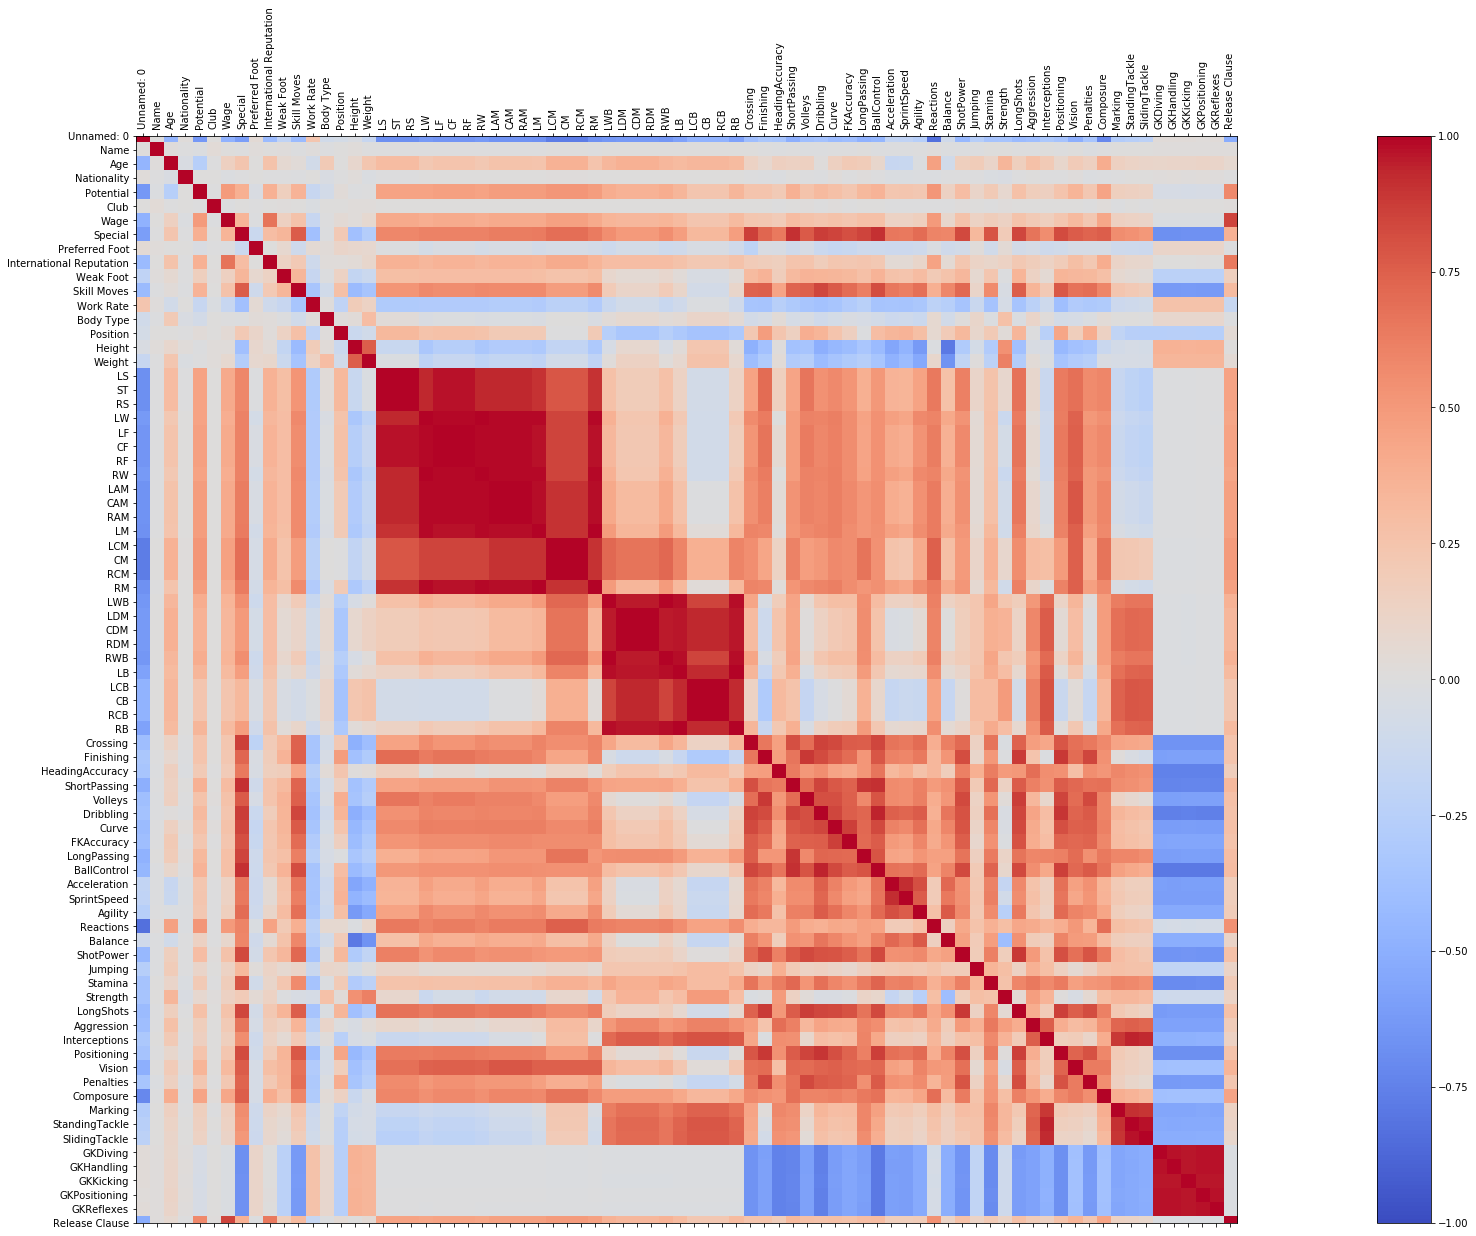

In [39]:
#Now that null values are taken care of I'll look into correlation between
#variables to determine which variables are less important
corr = X.corr()
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

In [40]:
#removing any variables that are too highly correlated
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print(to_drop)

['Skill Moves', 'Weight', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']


In [41]:

X = X.drop(columns=to_drop, axis=1)


In [42]:
print(X.columns)

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Potential', 'Club', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Work Rate', 'Body Type', 'Position', 'Height', 'LS', 'LWB',
       'Finishing', 'HeadingAccuracy', 'Acceleration', 'Jumping', 'Strength',
       'Aggression'],
      dtype='object')


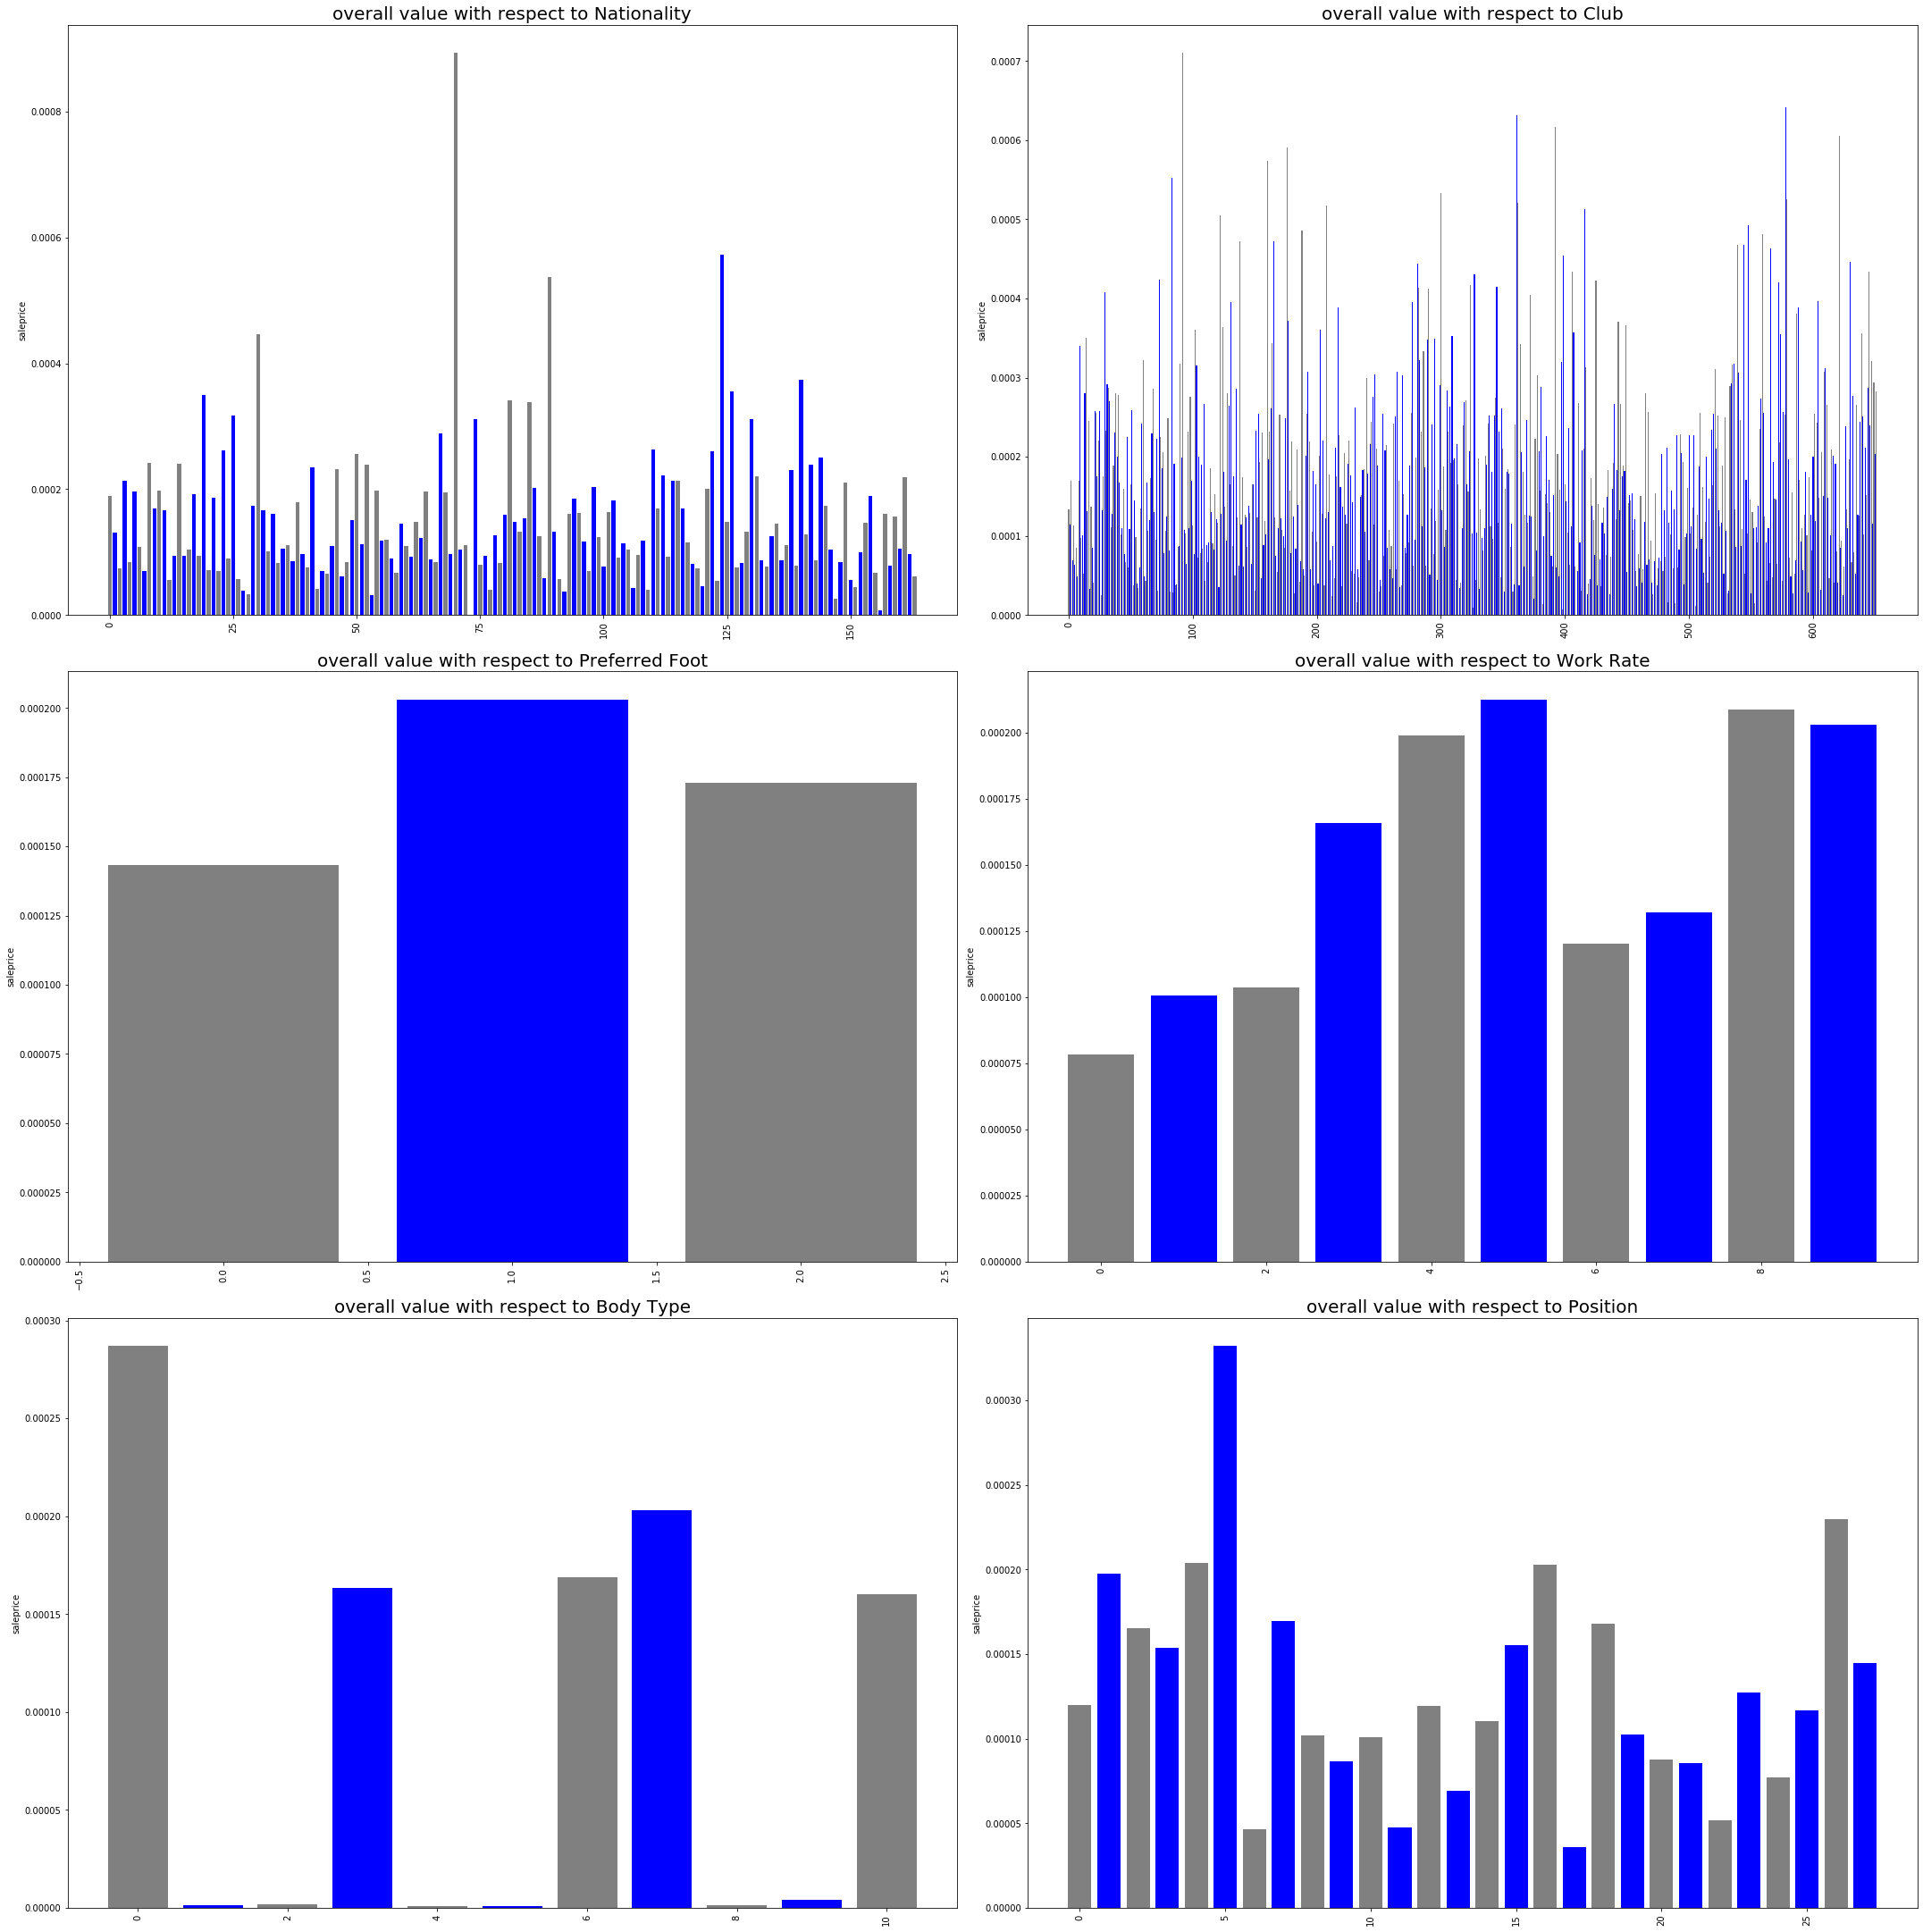

In [43]:
object_columns = ['Nationality',
                  'Club',
                  'Preferred Foot',
                  'Work Rate',
                  'Body Type',
                  'Position']

plt.figure(figsize=(30, 60))
for i, col in enumerate(object_columns):
    plt.subplot(len(object_columns), 2, i+1)
    plt.bar(fifa19.groupby(col)['value_overall'].mean(
    ).index, fifa19.groupby(col)['value_overall'].mean(), color=('grey', 'blue'))
    plt.ylabel('quality with respect to value')
    plt.xticks(rotation='vertical')
    plt.title('overall value with respect to {}'.format(col), fontsize=20)
    plt.tight_layout()
    #there's a lot of noise in the Nationality and Club

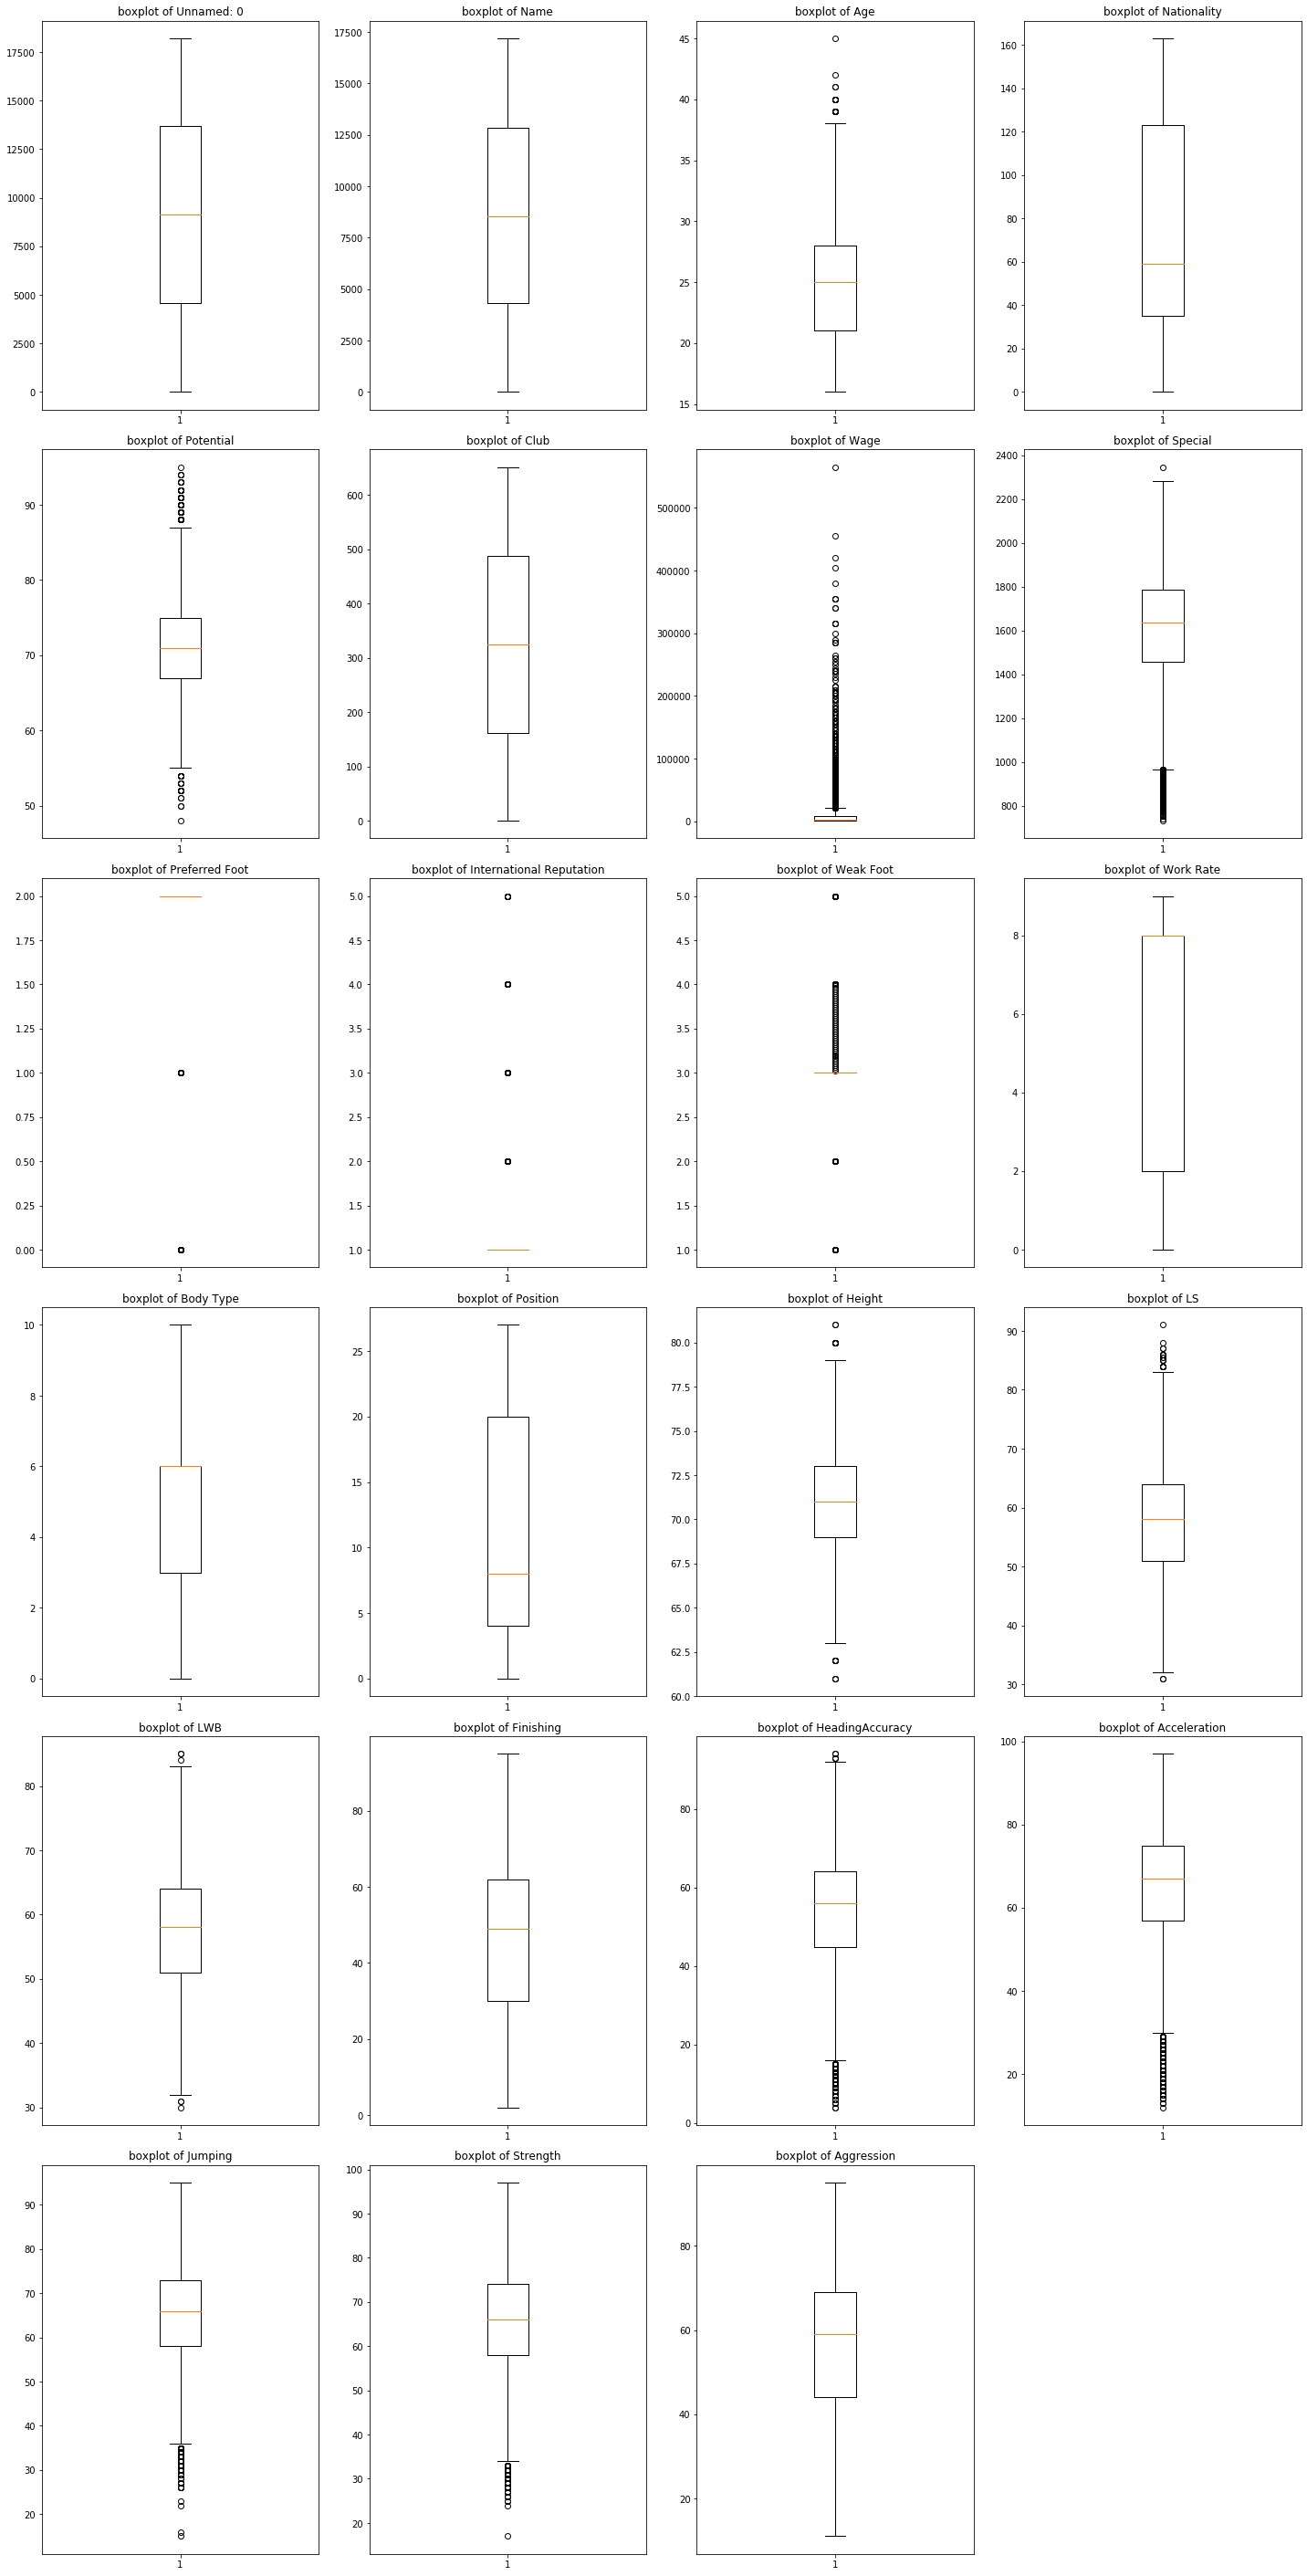

In [44]:
X_cont = X.select_dtypes(exclude='object')
fig = plt.figure(figsize=(20,150))
for i, col in enumerate(X_cont.columns):
    
    plt.subplot(len(X_cont.columns), 4, i+1)
    plt.boxplot(X[col])
    plt.title('boxplot of {}'.format(col))
    plt.tight_layout()


In [45]:
#Looks like I left Name in there. I'll drop that now
X = X.drop(columns='Name')
print(list(X.columns))

['Unnamed: 0', 'Age', 'Nationality', 'Potential', 'Club', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Work Rate', 'Body Type', 'Position', 'Height', 'LS', 'LWB', 'Finishing', 'HeadingAccuracy', 'Acceleration', 'Jumping', 'Strength', 'Aggression']


In [46]:
print(list(X.columns))

['Unnamed: 0', 'Age', 'Nationality', 'Potential', 'Club', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Work Rate', 'Body Type', 'Position', 'Height', 'LS', 'LWB', 'Finishing', 'HeadingAccuracy', 'Acceleration', 'Jumping', 'Strength', 'Aggression']


In [47]:

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
# I will now scale my X and Y and start running different models
scaler = preprocessing.StandardScaler()

#X = scaler.fit_transform(X)
y = fifa19['value_overall']

In [48]:
#starting with OLS
results = sm.OLS(y, X).fit()



print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)


# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



The number of observations in training set is 13466
The number of observations in test set is 4489


ValueError: shapes (4489,23) and (22,) not aligned: 23 (dim 1) != 22 (dim 0)

In [49]:

results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.563
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              1051.
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:25:40   Log-Likelihood:                      1.2645e+05
No. Observations:               17955   AIC:                                 -2.529e+05
Df Residuals:                   17933   BIC:                                 -2.527e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Unnamed: 0                 2.59e-08   6.37e-10     40.677      0.000    2.46e-08    2.71e-08
Age                       1.417e-05   5.63e-07     25.196      0.000    1.31e-05    1.53e-05
Nationality              -1.194e-08   3.32e-08     -0.360      0.719   -7.69e-08    5.31e-08
Potential                -3.566e-06   4.66e-07     -7.653      0.000   -4.48e-06   -2.65e-06
Club                      1.076e-08   8.39e-09      1.282      0.200   -5.68e-09    2.72e-08
Wage                      1.498e-09   1.04e-10     14.435      0.000    1.29e-09     1.7e-09
Special                   7.181e-09    2.6e-08      0.276      0.782   -4.38e-08    5.81e-08
Preferred Foot            2.069e-06   1.93e-06      1.070      0.285   -1.72e-06    5.86e-06
International Reputation  2.328e-05   5.66e-06      4.111      0.000    1.22e-05    3.44e-05
Weak Foot                -2.188e-06   2.61e-06     -0.837      0.402   -7.31e-06    2.93e-06
Work Rate                -1.861e-06    6.1e-07     -3.052      0.002   -3.06e-06   -6.66e-07
Body Type                  2.14e-06   8.98e-07      2.385      0.017    3.81e-07     3.9e-06
Position                 -4.304e-07   2.15e-07     -2.003      0.045   -8.52e-07   -9.29e-09
Height                    5.215e-06   6.78e-07      7.686      0.000    3.88e-06    6.54e-06
LS                       -2.575e-06   4.38e-07     -5.882      0.000   -3.43e-06   -1.72e-06
LWB                      -2.906e-06   4.47e-07     -6.506      0.000   -3.78e-06   -2.03e-06
Finishing                -1.723e-07   2.72e-07     -0.635      0.526   -7.04e-07     3.6e-07
HeadingAccuracy           -1.58e-06   1.88e-07     -8.404      0.000   -1.95e-06   -1.21e-06
Acceleration             -1.312e-06   1.83e-07     -7.161      0.000   -1.67e-06   -9.53e-07
Jumping                  -3.286e-08   1.54e-07     -0.213      0.831   -3.35e-07    2.69e-07
Strength                  -2.19e-06   2.04e-07    -10.762      0.000   -2.59e-06   -1.79e-06
Aggression                8.104e-07   1.79e-07      4.540      0.000    4.61e-07    1.16e-06
==============================================================================
Omnibus:                    32390.393   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57655525.691
Skew:                          13.125   Prob(JB):                         0.00
Kurtosis:                     279.365   Cond. No.                     8.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+04. This might indicate that there are
st

In [50]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
print(X.shape)
print(y.shape)
print(len(X.columns))

(4489, 23)
(13466, 22)
(4489,)
(13466,)
(17955, 22)
(17955,)
22


In [51]:
y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.605e+05
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:25:47   Log-Likelihood:                         -5805.6
No. Observations:               17955   AIC:                                  1.166e+04
Df Residuals:                   17933   BIC:                                  1.183e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Unnamed: 0                   0.0001   1.01e-06    148.427      0.000       0.000       0.000
Age                          0.0343      0.001     38.563      0.000       0.033       0.036
Nationality                 -0.0001   5.25e-05     -2.150      0.032      -0.000   -9.94e-06
Potential                   -0.0556      0.001    -75.440      0.000      -0.057      -0.054
Club                     -4.599e-05   1.33e-05     -3.467      0.001    -7.2e-05      -2e-05
Wage                     -4.699e-06   1.64e-07    -28.635      0.000   -5.02e-06   -4.38e-06
Special                     -0.0006   4.11e-05    -15.493      0.000      -0.001      -0.001
Preferred Foot              -0.0165      0.003     -5.398      0.000      -0.023      -0.011
International Reputation    -0.0743      0.009     -8.301      0.000      -0.092      -0.057
Weak Foot                   -0.0170      0.004     -4.116      0.000      -0.025      -0.009
Work Rate                   -0.0037      0.001     -3.879      0.000      -0.006      -0.002
Body Type                   -0.0198      0.001    -13.962      0.000      -0.023      -0.017
Position                    -0.0010      0.000     -2.916      0.004      -0.002      -0.000
Height                      -0.0742      0.001    -69.181      0.000      -0.076      -0.072
LS                          -0.0094      0.001    -13.593      0.000      -0.011      -0.008
LWB                         -0.0042      0.001     -5.882      0.000      -0.006      -0.003
Finishing                   -0.0008      0.000     -1.747      0.081      -0.002    9.14e-05
HeadingAccuracy           3.944e-05      0.000      0.133      0.894      -0.001       0.001
Acceleration                -0.0070      0.000    -24.224      0.000      -0.008      -0.006
Jumping                     -0.0014      0.000     -5.937      0.000      -0.002      -0.001
Strength                     0.0036      0.000     11.241      0.000       0.003       0.004
Aggression                   0.0021      0.000      7.333      0.000       0.002       0.003
==============================================================================
Omnibus:                     4406.334   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17286.694
Skew:                           1.176   Prob(JB):                         0.00
Kurtosis:                       7.192   Cond. No.                     8.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+04. This might indicate that there are
st

In [52]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor(n_estimators=100)
print(cross_val_score(rfr, X, y, cv=10))
rfr.fit(X,y).score(X,y)

[-0.04052538  0.87713927  0.91734909  0.72200321  0.941511    0.95818203
  0.94259946  0.88731755  0.74218448  0.14133078]


0.9994353743373907

In [53]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 7, metric = 'minkowski', p = 2)

knn.fit(X, y)

print(knn.score(X,y))
print(cross_val_score(knn, X, y, cv=10))

#print(knn.score(X_train, y_train))
#print(knn.score(X_test, y_test))
#y_pred = knn.predict(X_test)

0.9143356188012002
[-0.51993996  0.12344582 -0.05366634 -0.43479945 -0.11220556 -0.0128789
 -0.09510456 -0.00803459  0.09385551 -0.42904757]


In [54]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)